### Data Cleaning

In [459]:
import pandas as pd

# read data into a dataframe
df = pd.read_csv("fatal-police-shootings-data.csv")

# show the dataframe and the number of rows and columns
df

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5333,5815,TK TK,2020-05-20,shot,gun,NaN,M,NaN,Viera,FL,True,attack,Not fleeing,False
5334,5836,Michael Snyder,2020-05-24,shot,gun,44.0,M,NaN,Bulls Gap,TN,True,attack,Foot,False
5335,5837,Gary P. Dorton,2020-05-25,shot,knife,43.0,M,NaN,Jonesborough,TN,True,attack,Not fleeing,False
5336,5839,TK TK,2020-05-25,shot,gun,38.0,M,H,Houston,TX,False,attack,Not fleeing,False


In [460]:
# define name of race for each race letter (from the updated database at The Washington Post)
renamed_races = {"W": "White", "B": "Black", "H": "Hispanic", "A": "Asian", "N": "Native American", "O": "Other"}

# replace race letters with names of races
df["race"].replace(renamed_races, inplace=True)

# check to make sure all values are stored as the appropriate data type
df.dtypes

id                           int64
name                        object
date                        object
manner_of_death             object
armed                       object
age                        float64
gender                      object
race                        object
city                        object
state                       object
signs_of_mental_illness       bool
threat_level                object
flee                        object
body_camera                   bool
dtype: object

In [461]:
# ensure there are no duplicate rows
print("Duplicated rows:", df.duplicated().any())

Duplicated rows: False


In [462]:
# drop rows with only NaNs in columns other than id, name, and date
df.dropna(axis=0, how="all", subset=df.columns[3:], inplace=True)

# drop rows with NaNs in the race column (the actual race is required for model training)
df.dropna(axis=0, subset="race", inplace=True)

# initialize list of columns with NaNs
nan_columns = []

# check which columns contain NaNs and how many each contains
for name, column in df.items():
    na = column.isna()
    if na.any():
        nan_columns.append(name)
        print(f"{name}: {na.sum()} NaNs")

armed: 229 NaNs
age: 84 NaNs
gender: 1 NaNs
flee: 207 NaNs


In [463]:
# check the distribution of each column with NaNs to decide how to impute each
for column in nan_columns:
    print(df[column].value_counts())
    print()

armed
gun                    2637
knife                   686
unarmed                 310
undetermined            175
toy weapon              165
                       ... 
oar                       1
machete and gun           1
air conditioner           1
beer bottle               1
car, knife and mace       1
Name: count, Length: 90, dtype: int64

age
25.0    172
27.0    161
31.0    161
33.0    160
34.0    157
       ... 
13.0      1
91.0      1
79.0      1
78.0      1
81.0      1
Name: count, Length: 75, dtype: int64

gender
M    4514
F     216
Name: count, dtype: int64

flee
Not fleeing    2970
Car             785
Foot            623
Other           146
Name: count, dtype: int64



In [464]:
# fill NaNs in the armed column with the mode as shown in the output above: gun
df["armed"].fillna(df["armed"].mode()[0], inplace=True)

# fill NaNs in the age column with the median
df["age"].fillna(df["age"].median(), inplace=True)

# fill NaNs in the gender column with the mode as shown in the output above: M
df["gender"].fillna(df["gender"].mode()[0], inplace=True)

# fill NaNs in the flee column with the mode as shown in the output above: Not fleeing
df["flee"].fillna(df["flee"].mode()[0], inplace=True)

# check that there are no more NaNs in the dataframe
print("Any NaNs:", df.isna().any().any())

Any NaNs: False


### Exploratory Data Analysis

The top 10 states with most fatal shootings are shown in the bar chart below, with the top 5 being California, Texas, Florida, Arizona, and Colorado.

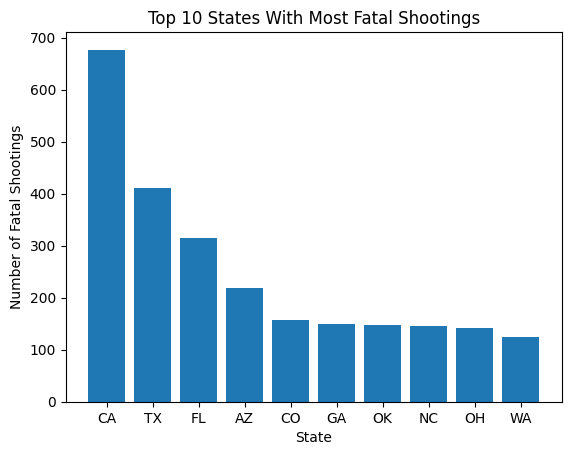

In [465]:
import matplotlib.pyplot as plt

# get top 10 states with most fatal shootings
state_counts = df["state"].value_counts()[:10]

# plot the number of fatal shootings for each state
plt.bar(state_counts.index, state_counts.values)
plt.title("Top 10 States With Most Fatal Shootings")
plt.xlabel("State")
plt.ylabel("Number of Fatal Shootings")
plt.show()

The top 5 cities with most fatal shootings are shown in the bar chart below, which are Los Angeles, Phoenix, Houston, San Antonio, and Las Vegas.

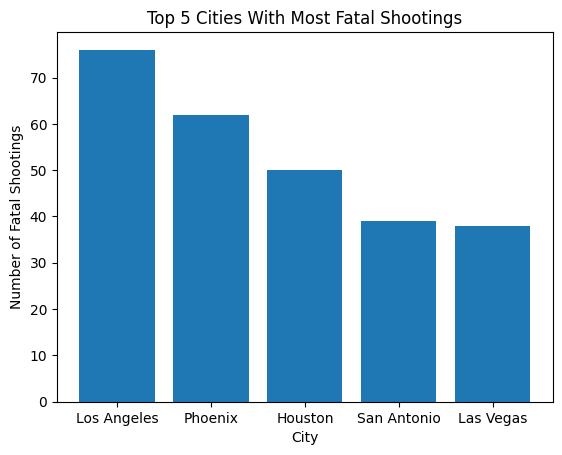

In [466]:
# get top 5 cities with most fatal shootings
city_counts = df["city"].value_counts()[:5]

# plot the number of fatal shootings for each city
plt.bar(city_counts.index, city_counts.values)
plt.title("Top 5 Cities With Most Fatal Shootings")
plt.xlabel("City")
plt.ylabel("Number of Fatal Shootings")
plt.show()

The top 3 ways to be armed in fatal shootings are shown in the bar chart below, which are guns, knives, and toy weapons. Guns were used significantly more often than any other way to be armed. However, being unarmed and having an undetermined armed status occurred more often than being armed with toy weapons.

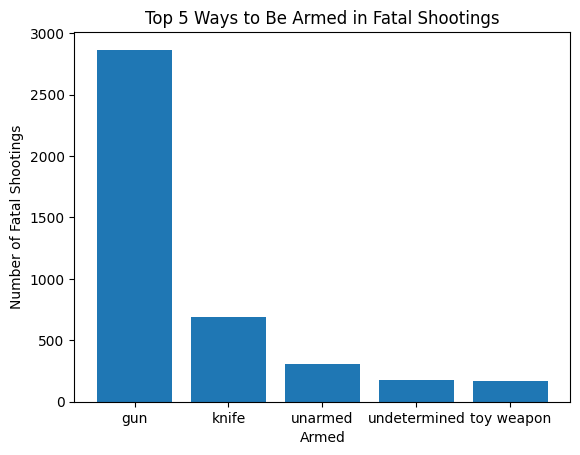

In [467]:
# get top 5 ways to be armed
armed_counts = df["armed"].value_counts()[:5]

# plot the number of fatal shootings for each way to be armed
plt.bar(armed_counts.index, armed_counts.values)
plt.title("Top 5 Ways to Be Armed in Fatal Shootings")
plt.xlabel("Armed")
plt.ylabel("Number of Fatal Shootings")
plt.show()

The age distribution of victims in fatal shootings is shown in the histogram below. It is skewed to the right and shows that younger people (25 to 35 years old) were involved more often in fatal shootings. The very tall bar is due to median imputation of missing ages.

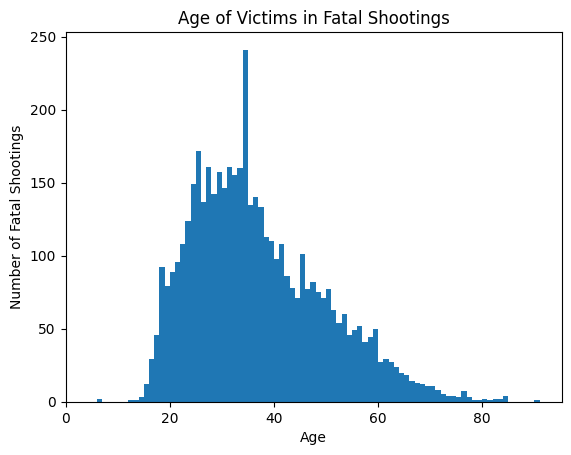

In [468]:
# plot age distribution
plt.hist(df["age"], bins=85)
plt.title("Age of Victims in Fatal Shootings")
plt.xlabel("Age")
plt.ylabel("Number of Fatal Shootings")
plt.xlim(left=0)
plt.show()

The age distribution for each race is shown in each of the histograms below. All of the distributions are skewed to the right and show that younger people were involved more often in fatal shootings.

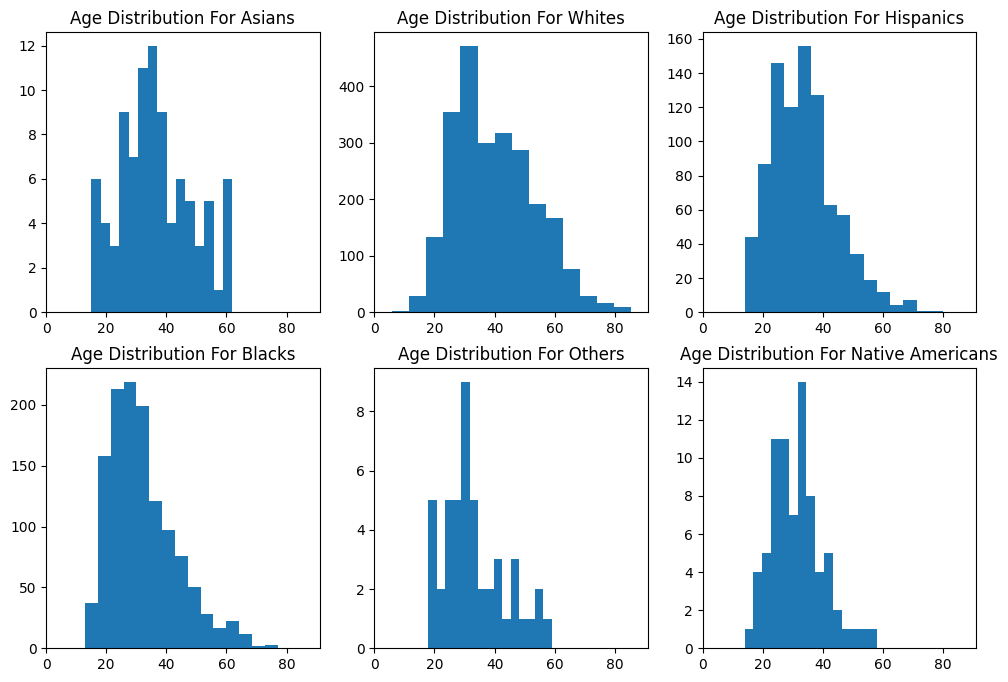

In [469]:
# get all races
races = df["race"].unique()

# get highest age to set x-axis limit
max_age = df["age"].max()

# plot age distributions of each race
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
for ax, race in zip(axes.flatten(), races):
    ax.hist(df["age"][df["race"] == race], bins=15)
    ax.set_title("Age Distribution For " + race + "s")
    ax.set_xlim(0, max_age)
plt.show()

The number and proportion of people killed per race are shown in the bar chart and pie chart below. White people were killed the most in fatal shootings, accounting for about 50% of the total deaths from fatal shootings. The second most killed in fatal shootings were black people, but they were killed almost two times less than white people. Asian and Native American people accounted for a very small proportion of the total deaths from fatal shootings.

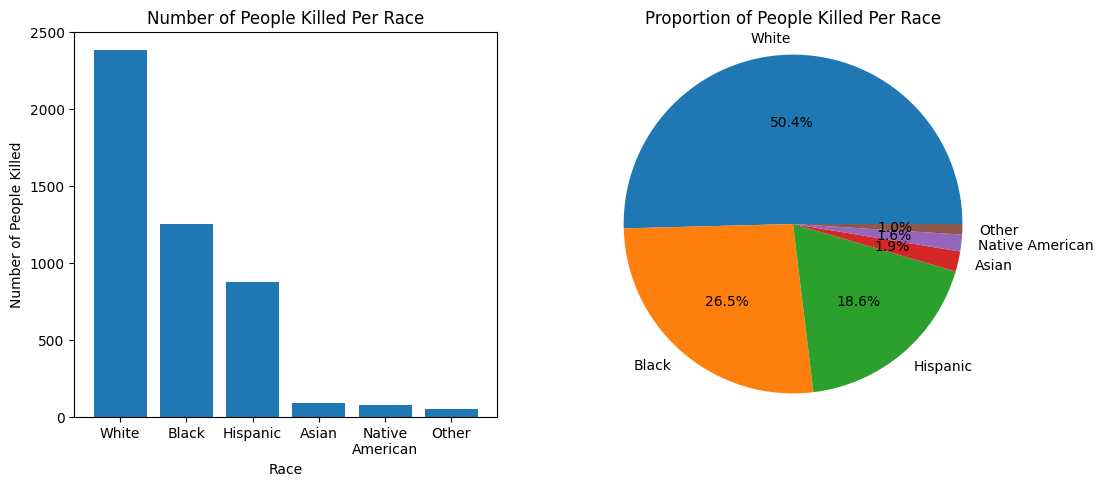

In [470]:
# get counts of each race
race_counts = df["race"].value_counts()

# plot the number and proportion of people killed per race
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].bar(race_counts.rename({"Native American": "Native\nAmerican"}).index, race_counts.values)
axes[0].set_title("Number of People Killed Per Race")
axes[0].set_xlabel("Race")
axes[0].set_ylabel("Number of People Killed")
axes[1].pie(race_counts.values, labels=race_counts.index, autopct="%1.1f%%", radius=1.1)
axes[1].set_title("Proportion of People Killed Per Race")
plt.show()

### Data Preprocessing

In [471]:
# check the number of unique values in each column to see if any further categorization is needed
for name, column in df.items():
    print(f"{name}: {column.nunique()}")

id: 4731
name: 4689
date: 1757
manner_of_death: 2
armed: 90
age: 75
gender: 2
race: 6
city: 2236
state: 51
signs_of_mental_illness: 2
threat_level: 3
flee: 4
body_camera: 2


In [472]:
# initialize dictionary for new armed categories
# armed_categories = {}

# manually input the new category of each old armed category
# for x in df["armed"].unique():
#     category = input("Category for " + x + ":")
#     armed_categories[x] = category

# print the dictionary out
# print(armed_categories)

# manually categorize all categories in armed column by using the above commented code
armed_categories = {'gun': 'gun', 
                    'unarmed': 'unarmed', 
                    'toy weapon': 'toy weapon', 
                    'nail gun': 'other', 
                    'knife': 'melee weapon', 
                    'shovel': 'melee weapon', 
                    'hammer': 'melee weapon', 
                    'hatchet': 'melee weapon', 
                    'undetermined': 'undetermined', 
                    'sword': 'melee weapon', 
                    'machete': 'melee weapon', 
                    'box cutter': 'melee weapon', 
                    'metal object': 'other', 
                    'screwdriver': 'melee weapon', 
                    'lawn mower blade': 'melee weapon', 
                    'flagpole': 'melee weapon', 
                    'guns and explosives': 'gun/incendiary device', 
                    'cordless drill': 'other', 
                    'metal pole': 'melee weapon', 
                    'Taser': 'projectile launcher', 
                    'metal pipe': 'melee weapon', 
                    'metal hand tool': 'melee weapon', 
                    'blunt object': 'melee weapon', 
                    'metal stick': 'melee weapon', 
                    'sharp object': 'melee weapon', 
                    'meat cleaver': 'melee weapon', 
                    'carjack': 'other', 
                    'chain': 'other', 
                    "contractor's level": 'other', 
                    'unknown weapon': 'unknown weapon', 
                    'stapler': 'other', 
                    'crossbow': 'projectile launcher', 
                    'bean-bag gun': 'projectile launcher', 
                    'baseball bat and fireplace poker': 'melee weapon', 
                    'straight edge razor': 'melee weapon', 
                    'gun and knife': 'gun/melee weapon', 
                    'ax': 'melee weapon', 
                    'brick': 'other', 
                    'baseball bat': 'melee weapon', 
                    'hand torch': 'incendiary device', 
                    'chain saw': 'melee weapon', 
                    'garden tool': 'melee weapon', 
                    'scissors': 'melee weapon', 
                    'pole': 'melee weapon', 
                    'pick-axe': 'melee weapon', 
                    'flashlight': 'other', 
                    'spear': 'melee weapon', 
                    'chair': 'other', 
                    'pitchfork': 'melee weapon', 
                    'hatchet and gun': 'melee weapon/gun', 
                    'rock': 'other', 
                    'piece of wood': 'other', 
                    'bayonet': 'melee weapon', 
                    'pipe': 'melee weapon', 
                    'glass shard': 'other', 
                    'motorcycle': 'vehicle', 
                    'pepper spray': 'other', 
                    'metal rake': 'melee weapon', 
                    'baton': 'melee weapon', 
                    'crowbar': 'melee weapon', 
                    'oar': 'melee weapon', 
                    'machete and gun': 'melee weapon/gun', 
                    'air conditioner': 'other', 
                    'pole and knife': 'melee weapon', 
                    'beer bottle': 'other', 
                    'baseball bat and bottle': 'melee weapon/other', 
                    'fireworks': 'incendiary device', 
                    'pen': 'other', 
                    'chainsaw': 'melee weapon', 
                    'gun and sword': 'gun/melee weapon', 
                    'gun and car': 'gun/vehicle', 
                    'vehicle': 'vehicle', 
                    'pellet gun': 'projectile launcher', 
                    'claimed to be armed': 'claimed to be armed', 
                    'BB gun': 'projectile launcher', 
                    'incendiary device': 'incendiary device', 
                    'samurai sword': 'melee weapon', 
                    'bow and arrow': 'projectile launcher', 
                    'gun and vehicle': 'gun/vehicle', 
                    'vehicle and gun': 'vehicle/gun', 
                    'wrench': 'melee weapon', 
                    'walking stick': 'melee weapon', 
                    'barstool': 'other', 
                    'BB gun and vehicle': 'projectile launcher/vehicle', 
                    'wasp spray': 'other', 
                    'air pistol': 'projectile launcher', 
                    'baseball bat and knife': 'melee weapon', 
                    'vehicle and machete': 'vehicle/melee weapon', 
                    'ice pick': 'melee weapon', 
                    'car, knife and mace': 'vehicle/melee weapon'}

# replace old armed categories with new armed categories
df["armed"].replace(armed_categories, inplace=True)

# check that the old armed categories were successfully replaced
print(df["armed"].unique())

['gun' 'unarmed' 'toy weapon' 'other' 'melee weapon' 'undetermined'
 'gun/incendiary device' 'projectile launcher' 'unknown weapon'
 'gun/melee weapon' 'incendiary device' 'melee weapon/gun' 'vehicle'
 'melee weapon/other' 'gun/vehicle' 'claimed to be armed' 'vehicle/gun'
 'projectile launcher/vehicle' 'vehicle/melee weapon']


In [473]:
# define features to be one-hot encoded
features = ["manner_of_death", "armed", "gender", "threat_level", "flee"]

# perform one-hot encoding on those features and drop first dummy column
encoded_df = pd.get_dummies(df, columns=features, drop_first=True)

# check if features were succesfully encoded
print(encoded_df.columns)

Index(['id', 'name', 'date', 'age', 'race', 'city', 'state',
       'signs_of_mental_illness', 'body_camera',
       'manner_of_death_shot and Tasered', 'armed_gun',
       'armed_gun/incendiary device', 'armed_gun/melee weapon',
       'armed_gun/vehicle', 'armed_incendiary device', 'armed_melee weapon',
       'armed_melee weapon/gun', 'armed_melee weapon/other', 'armed_other',
       'armed_projectile launcher', 'armed_projectile launcher/vehicle',
       'armed_toy weapon', 'armed_unarmed', 'armed_undetermined',
       'armed_unknown weapon', 'armed_vehicle', 'armed_vehicle/gun',
       'armed_vehicle/melee weapon', 'gender_M', 'threat_level_other',
       'threat_level_undetermined', 'flee_Foot', 'flee_Not fleeing',
       'flee_Other'],
      dtype='object')


In [474]:
# split each column corresponding to two categories into the two columns corresponding to each category
for name, column in encoded_df.filter(regex="/").items():
    categories = name[6:].split("/")
    for index, value in column[column].items():
        encoded_df.at[index, "armed_" + categories[0]] = True
        encoded_df.at[index, "armed_" + categories[1]] = True
    encoded_df.drop(columns=name, inplace=True)

# drop columns that will not be trained on
encoded_df.drop(columns=["id", "name", "date", "city", "state"], inplace=True)

# check that encoded dataframe only contains columns that will be trained on
print(encoded_df.columns)

Index(['age', 'race', 'signs_of_mental_illness', 'body_camera',
       'manner_of_death_shot and Tasered', 'armed_gun',
       'armed_incendiary device', 'armed_melee weapon', 'armed_other',
       'armed_projectile launcher', 'armed_toy weapon', 'armed_unarmed',
       'armed_undetermined', 'armed_unknown weapon', 'armed_vehicle',
       'gender_M', 'threat_level_other', 'threat_level_undetermined',
       'flee_Foot', 'flee_Not fleeing', 'flee_Other'],
      dtype='object')


In [475]:
from sklearn.model_selection import train_test_split

# randomly split dataframe into training and test data using stratified splits for race
training, test = train_test_split(encoded_df, train_size=0.8, random_state=0, shuffle=True, stratify=encoded_df["race"])

# check that the training and test data have similar ratios of each race
print(f"Out of {training.shape[0]} training samples:")
print(training["race"].value_counts() / training.shape[0])
print()
print(f"Out of {test.shape[0]} test samples:")
print(test["race"].value_counts() / test.shape[0])

Out of 3784 training samples:
race
White              0.504228
Black              0.265063
Hispanic           0.185518
Asian              0.019292
Native American    0.016121
Other              0.009778
Name: count, dtype: float64

Out of 947 test samples:
race
White              0.503696
Black              0.265048
Hispanic           0.185850
Asian              0.019007
Native American    0.015839
Other              0.010560
Name: count, dtype: float64


In [476]:
# perform limited amount of random oversampling of the minority classes (Asian, Native American, Other)
rand_samples = [training[training["race"] == race].sample(frac=5, replace=True, random_state=0) for race in ["Asian", "Native American", "Other"]]

# add random samples to the training data
new_training = pd.concat([training, *rand_samples], axis=0)

# split the new training data into feature matrix (X) and target vector (y)
X_train = new_training.drop(columns="race")
y_train = new_training["race"]

# split the test data into feature matrix (X) and target vector (y)
X_test = test.drop(columns="race")
y_test = test["race"]

# check the ratios of each class after oversampling
y_train.value_counts() / y_train.shape[0]

race
White              0.411296
Black              0.216210
Hispanic           0.151326
Asian              0.094417
Native American    0.078896
Other              0.047855
Name: count, dtype: float64

### Data Modeling

In [477]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# function for reporting test accuracy, precision, recall, and F-score of a trained model
def performance_metrics(model):

    # make predictions on the test data
    y_pred = model.predict(X_test)

    # calculate test accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # calculate test precision, recall, and F-score, weighted by the number of positive instances of each class
    precision, recall, f_score, support = precision_recall_fscore_support(y_test, y_pred, labels=model.classes_, average="weighted", zero_division=0.0)

    # return the performance metrics in a series
    return pd.Series([accuracy, precision, recall, f_score], index=["accuracy", "precision", "recall", "F-score"])

In [478]:
from sklearn.linear_model import LogisticRegression

# train a logistic regression classifier with regularization that balances the classes through weights
log_reg = LogisticRegression(class_weight="balanced", random_state=0, solver="newton-cholesky")
log_reg.fit(X_train, y_train)

# evaluate classifier performance on test data
performance_metrics(log_reg)

accuracy     0.344245
precision    0.505756
recall       0.344245
F-score      0.401303
dtype: float64

In [479]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# define grid of hyperparameters (number of neighbors k)
parameters = {"n_neighbors": range(1, 101, 2)}

# create a stratified 5-fold cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# perform hyperparameter grid search with stratified 5-fold cross-validation using F-score for distance-weighted k-nearest neighbors
grid_cv = GridSearchCV(KNeighborsClassifier(weights="distance"), parameters, scoring="f1_weighted", cv=cv)

# train the best k-nearest neighbor classifier
grid_cv.fit(X_train, y_train)

# evaluate classifier performance on test data
print(grid_cv.best_params_)
performance_metrics(grid_cv)

{'n_neighbors': 75}


accuracy     0.458289
precision    0.433461
recall       0.458289
F-score      0.435859
dtype: float64

In [480]:
from sklearn.tree import DecisionTreeClassifier

# train a decision tree classifier that balances the classes through weights
dec_tree = DecisionTreeClassifier(random_state=0, class_weight="balanced")
dec_tree.fit(X_train, y_train)

# evaluate classifier performance on test data
performance_metrics(dec_tree)

accuracy     0.337909
precision    0.423361
recall       0.337909
F-score      0.371810
dtype: float64

The logistic regression, k-nearest neighbor, and decision tree classifiers all failed to provide high test accuracies, precision, recall, and F-scores.

The test accuracies for the logistic regression and decision tree classifiers were only about 34%. The test accuracy for the k-nearest neighbor classifier was higher at about 46%, which may be due to the class imbalance in the dataset. The logistic regression and decision tree classifiers weighed smaller classes more, but the k-nearest neighbor classifier did not do that.

The logistic regression classifier had the highest weighted precision at about 51%, while the k-nearest neighbor classifier had the highest weighted F-score at about 44%, possibly due to class imbalance. It should be noted that weighted recall is equivalent to accuracy and is shown to be so in the results.

It seems that the classifiers above are able to predict the race of a person based on the features provided to a certain extent. A classifier guessing at random would have a test accuracy of about 1/6 = 16.67%. The performance metrics of the classifiers being higher signify a relationship between the features used and the race of a person.

However, the performance metrics are overall still not very satisfactory. This may be due to the features chosen to be trained on. It is possible that including date, city, and state and excluding certain features will increase classifier performance. The poor performance may also be due to the lack of variety in the data for the minority classes: Asian, Native American, and Other. This is all under the assumption that race can be predicted from the available data.

### Used Resources

* https://www.washingtonpost.com/graphics/investigations/police-shootings-database/